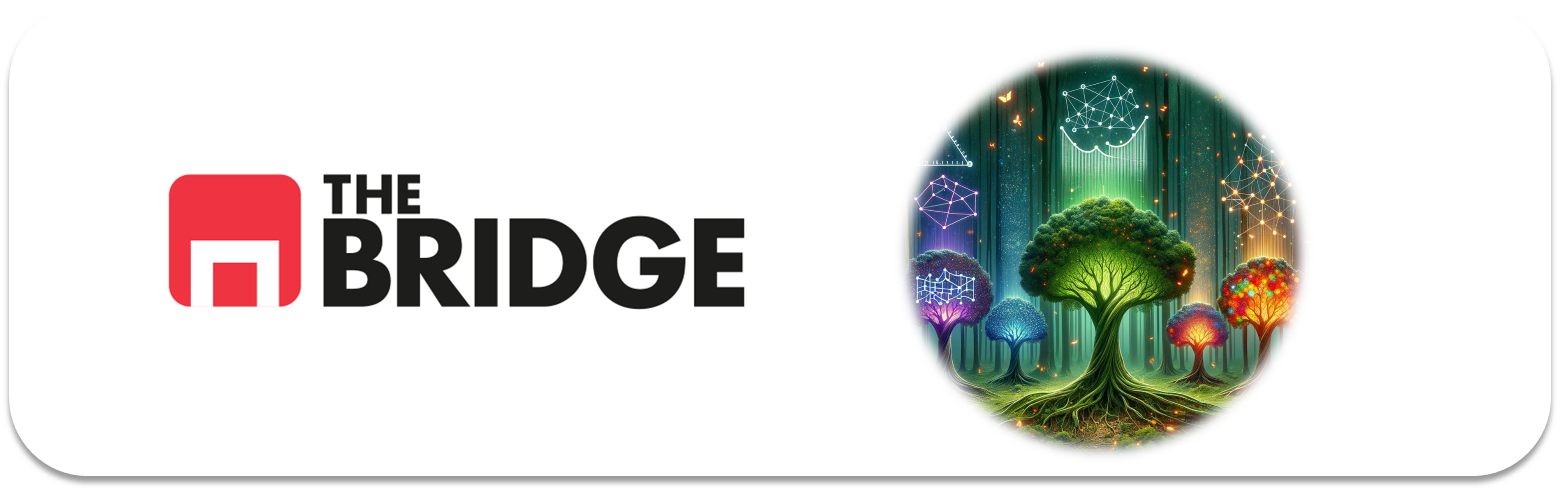

## PRACTICA OBLIGATORIA: **Ensamblado de modelos, bagging, boosting, random forest y gbts**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bootcampviztools as bt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

In [3]:
# Cargar los datos
df = pd.read_csv(url, names=names)

df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Comprobamos que no hay valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Calculamos la cardinalidad
cardinalidad = df.nunique()
print(cardinalidad)

preg      17
plas     136
pres      47
skin      51
test     186
mass     248
pedi     517
age       52
class      2
dtype: int64


In [6]:
df.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menoss tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

En primer lugar separamos en train y test para poder empezar a visualizar las features del entrenamiento.

In [7]:
# Separar en train y test
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

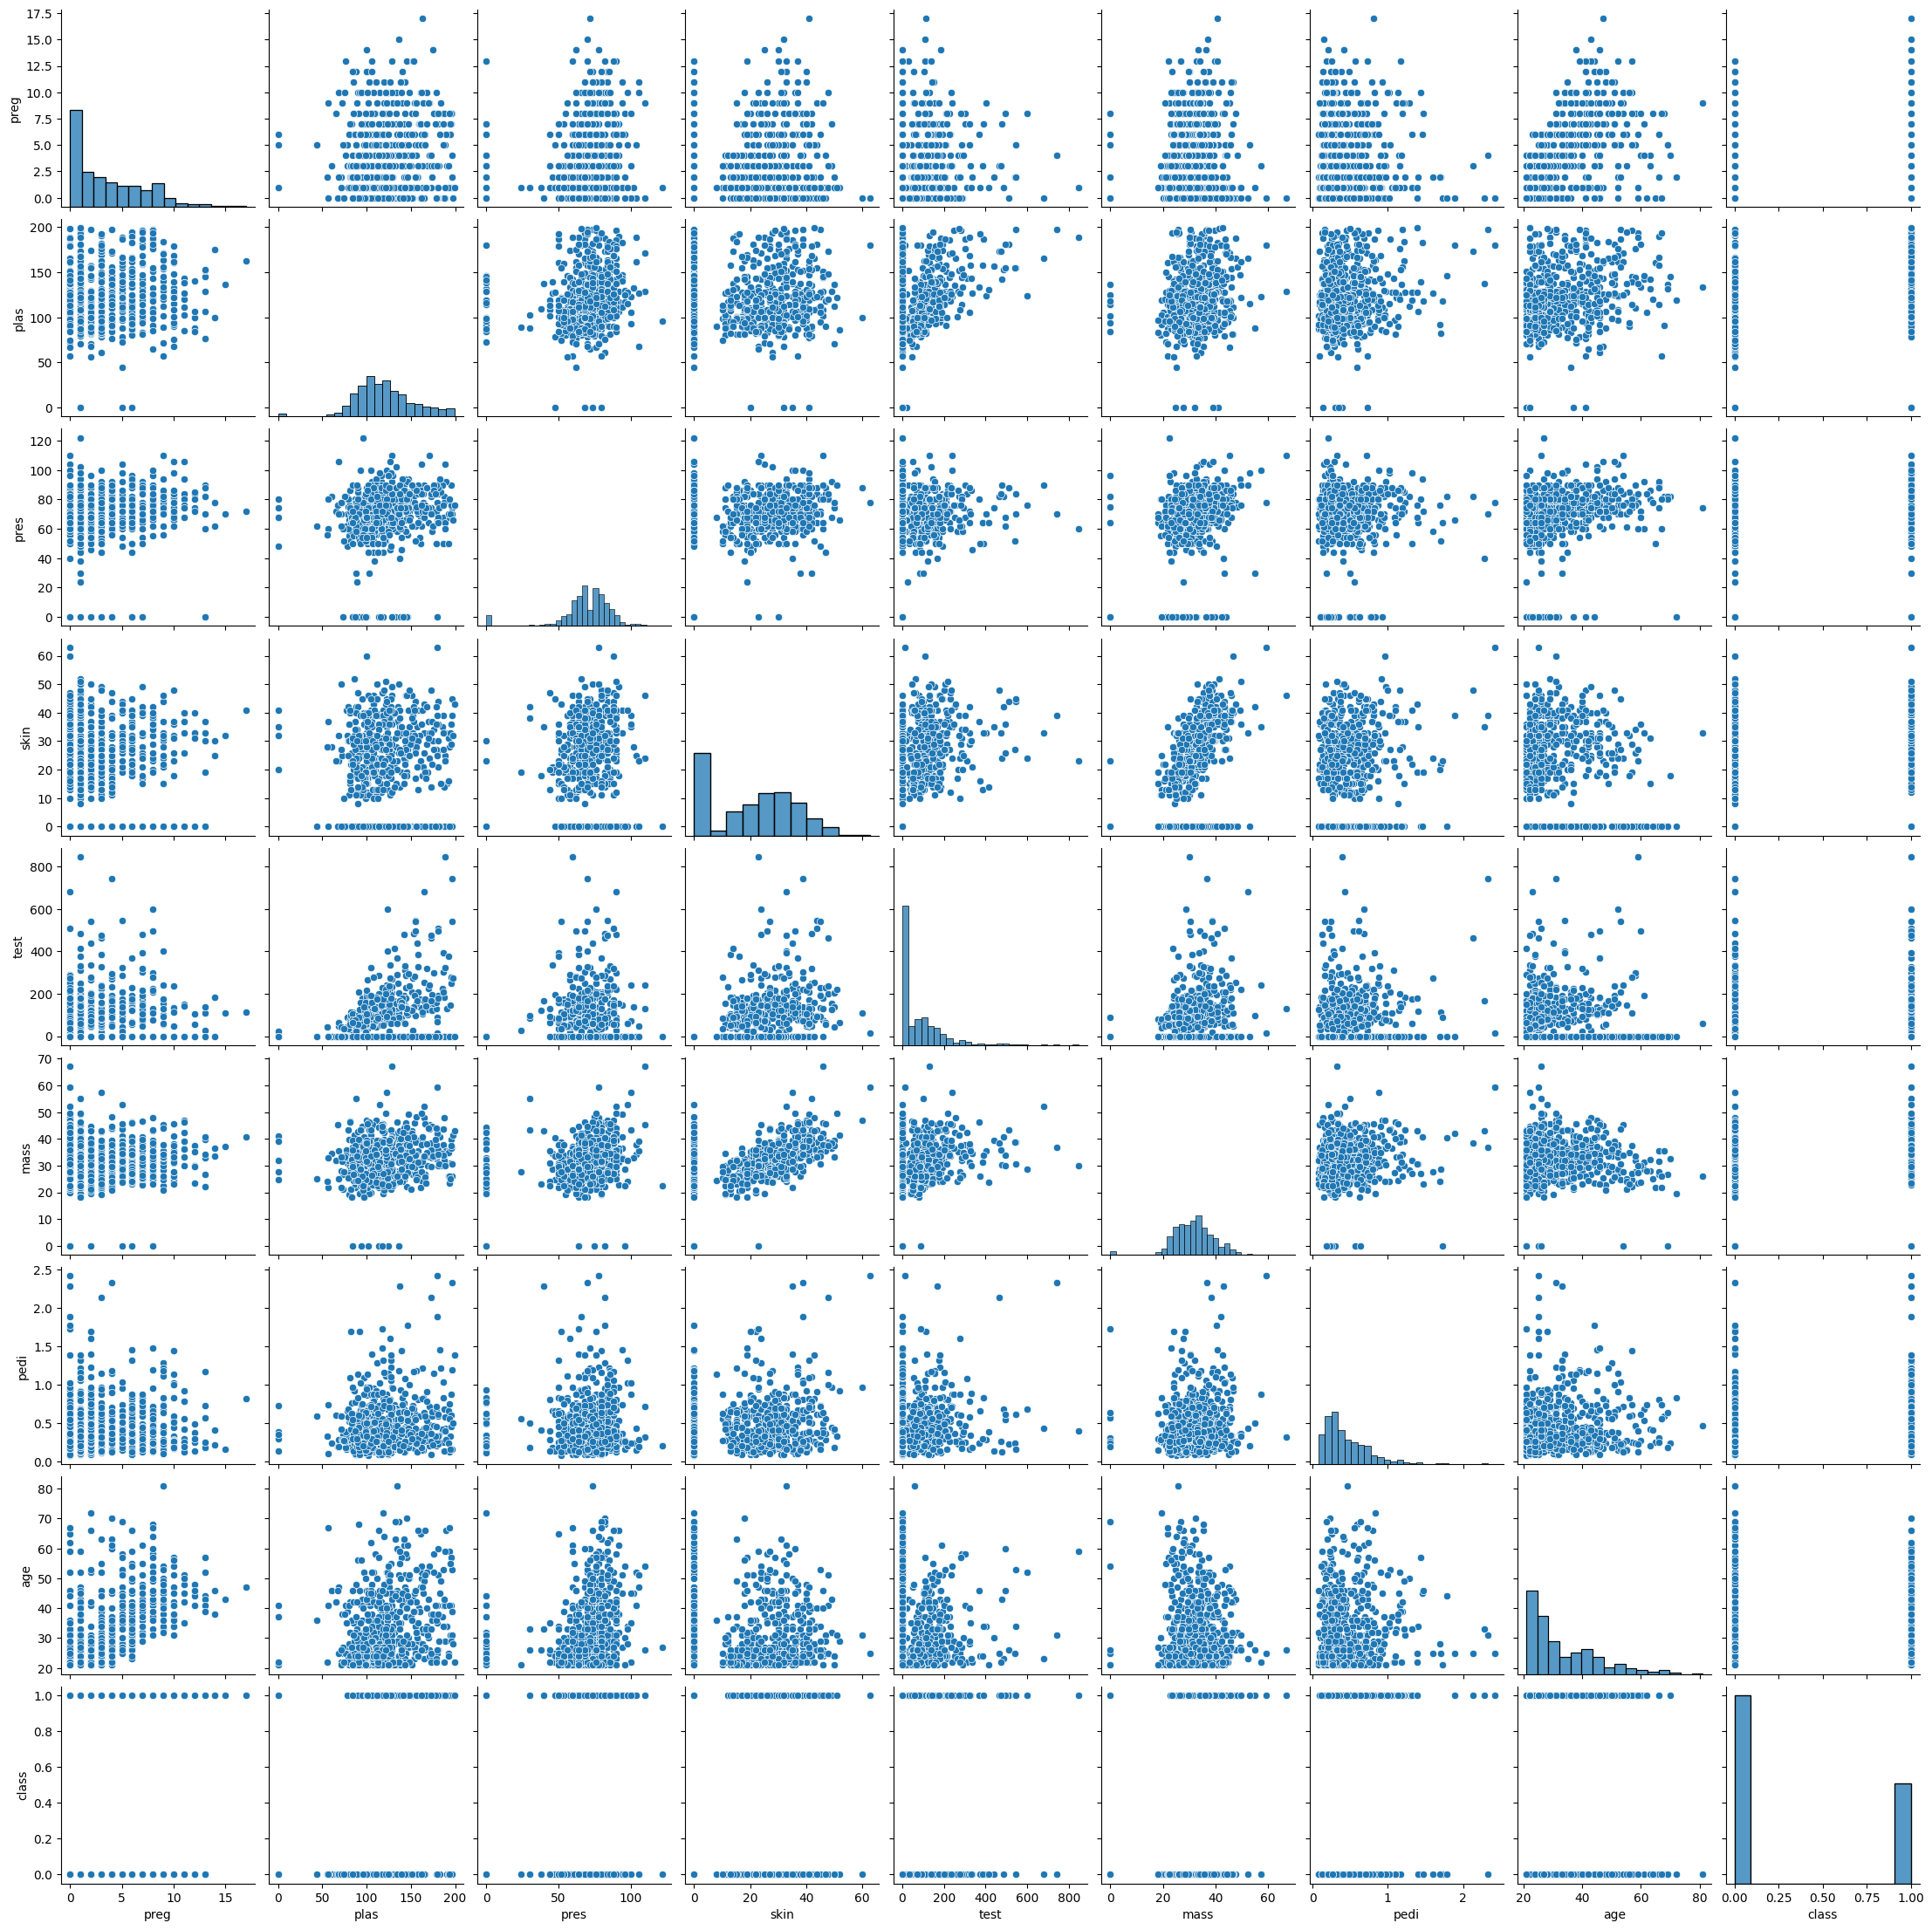

In [8]:
sns.pairplot(train_set)

Como se puede ver, aunque no hay NaNs, hay valores anómalos. En algunas features hay muchos 0s que no corresponden y que se van a sustituir por la mediana para que no afecten.

In [9]:
cols_with_zeros = ['plas', 'pres', 'skin', 'test', 'mass']
train_set[cols_with_zeros] = train_set[cols_with_zeros].replace(0, np.nan)
test_set[cols_with_zeros] = test_set[cols_with_zeros].replace(0, np.nan)

train_set.fillna(train_set.median(), inplace=True)
test_set.fillna(train_set.median(), inplace=True) # se le pone la media del train que es la que sabemos.

Se va a ver la distribución del target, que está algo desbalanceado.

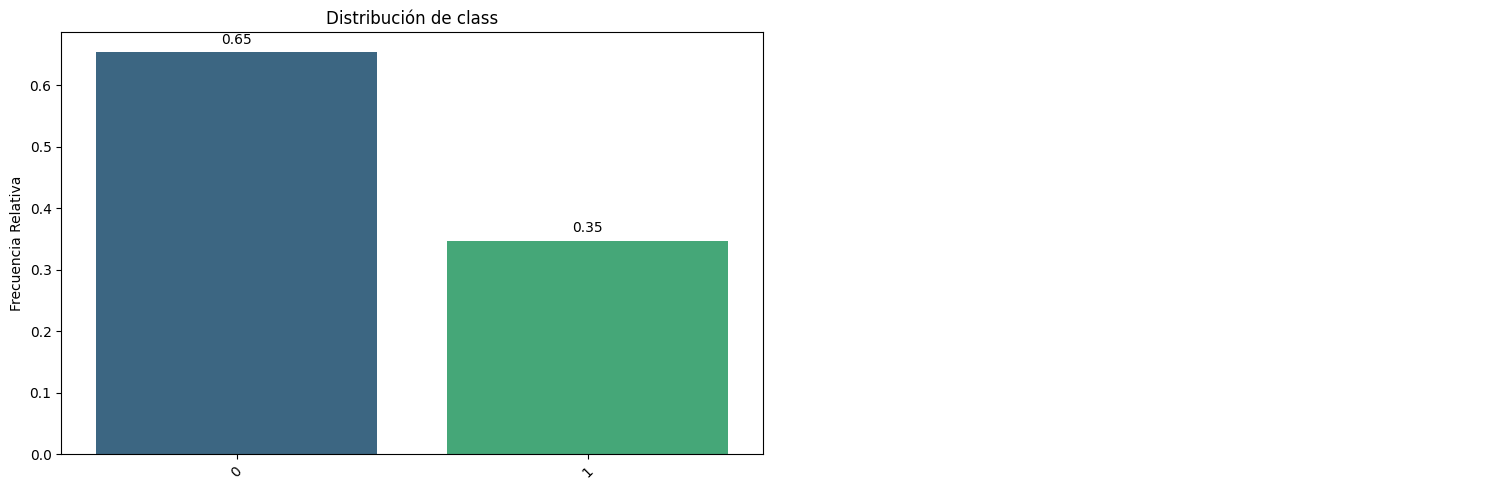

In [10]:
target = 'class'

bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores= True, relativa= True)

Se divide en X y.

In [11]:
X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]

X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]


Se definen los modelos que se van a utilizar.

In [12]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}


Se evalúan los modelos con validación cruzada.

In [13]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall') # recall teniendo en cuenta el problema de negocio de este caso concreto
    print(f"{name}: Accuracy = {np.mean(scores):.4f}")

Random Forest: Accuracy = 0.5918
[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Sobre el mejor modelo, se optimizan los hiperparámetros.

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
}
gs = GridSearchCV(XGBClassifier(random_state=42), param_grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)

# Mejor modelo
best_model = gs.best_estimator_
print(f"Best parameters for XGBClassifier: {gs.best_params_}")

Best parameters for XGBClassifier: {'max_depth': 3, 'n_estimators': 100}


Se evalua el modelo con los mejores hiperparámetros con el conjunto de test.


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.77        99
           1       0.60      0.73      0.66        55

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.73      0.73       154



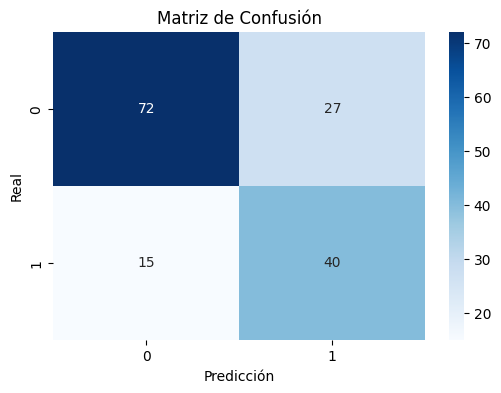

In [15]:
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Ver resultados
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


Es importante el recall en la clase 1, ya que es lo que quieres predecir. Se ha conseguido un 73%, aunque se compromete la precision.